In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from __future__ import unicode_literals

In [2]:
temp = pd.read_csv('winemag.csv', index_col = False)

In [3]:
from sklearn.model_selection import train_test_split
X = temp
X_train, X_test = train_test_split(X, test_size=0.9, random_state=42)

In [4]:
df = X_train

In [5]:
remove = ['Unnamed: 0', 'region_1', 'region_2', 'designation','taster_twitter_handle', 'province', 
          'title', 'winery','variety','country','points','price']
df = df.drop(remove,1)

In [6]:
df = df.reset_index(drop=True)

In [7]:
print(df.head())

                                         description       taster_name
0  This is classic Oregon Pinot Noir at its most ...      Paul Gregutt
1  A blend of fruit from Arianses, StoneTree and ...  Sean P. Sullivan
2  Very perfumed, this lightly sweet and poised w...        Roger Voss
3  Made entirely with Negroamaro, this opens with...     Kerin O’Keefe
4  Red berry, aromatic herb, pressed violet and d...     Kerin O’Keefe


In [8]:
#Drop all other rows with country as NA.
df = df.dropna()

In [9]:
from sklearn.model_selection import train_test_split
y = df['taster_name']
y_train, y_test = train_test_split(y, test_size=0.25, random_state=42)

In [10]:
df = df.drop(['taster_name'],1)

In [11]:
def text_cleaner(text):
    text = re.sub(r'--', '', text)
    text = re.sub('[\[].*?![\]]', "", text)
    text = ' '.join(text.split())
    return text

In [13]:
df['description'] = df['description'].apply(text_cleaner)

In [56]:
#taster_names = df.taster_name.unique()

In [12]:
taster_reviews = []
for name in taster_names:
    temp_taster_reviews = df[df['taster_name']==name]
    temp_taster_reviews = " \n".join(temp_taster_reviews['description'])
    taster_reviews.append(temp_taster_reviews)

In [14]:
taster_doc = df['description']

In [19]:
#nlp = spacy.load('en')

In [20]:
#taster_doc = []
#for i in range(len(taster_names)):
    #taster_doc.append(nlp(taster_reviews[i]))

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(taster_doc, test_size=0.25, random_state=42)

vectorizer = TfidfVectorizer(
                            stop_words='english', 
                            lowercase=True, #convert everything to lower case
                            use_idf=True, #use inverse document frequencies in our weighting
                            norm=u'l2', #applies a correction factor so short and long paragraphs are treated equally
                            smooth_idf=True, #adds 1 to all document frequencies, prevents divide by 0 errors
                            ngram_range=(0,3),
                            analyzer='word'
                           )

#applying the vectorizer
taster_doc_tfidf = vectorizer.fit_transform(taster_doc)
print('Number of features: %d' % taster_doc_tfidf.get_shape()[1])

#Split into train and test.
X_train_tfidf, X_test_tfidf = train_test_split(taster_doc_tfidf, test_size=0.25, random_state=42)
#Reshape the vectorizer
X_train_tfidf_csr = X_train_tfidf.tocsr() #Return a copy of this matrix in Compressed Sparse Row format

#Number of paragraphs
n = X_train_tfidf_csr.shape[0]

tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, list the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

Number of features: 340928


In [16]:
from sklearn.decomposition import TruncatedSVD #Singular Value Decomposition
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Reduce the feature space to 500
svd = TruncatedSVD(500)
lsa = make_pipeline(svd, Normalizer(copy=False)) #LSA is latent semantic analysis

#Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained = svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print('Percent variance captured by all components:', total_variance*100)

Percent variance captured by all components: 14.586179002


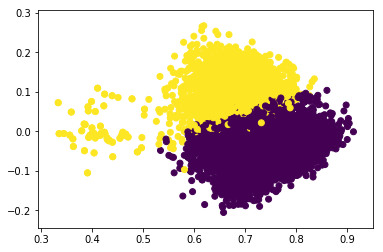

Comparing k-means train and pred solutions:
col_0                  0     1
taster_name                   
Alexander Peartree    29     2
Anna Lee C. Iijima   300     8
Anne Krebiehl MW     261     9
Carrie Dykes          10     0
Fiona Adams            1     0
Jeff Jenssen          30     1
Jim Gordon           300    40
Joe Czerwinski       387    12
Kerin O’Keefe        760     8
Lauren Buzzeo        147     5
Matt Kettmann        464     4
Michael Schachner   1174     8
Mike DeSimone         41     0
Paul Gregutt         650    29
Roger Voss           123  1708
Sean P. Sullivan     397    18
Susan Kostrzewa       78     0
Virginie Boone       690    53


In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_train_lsa)

# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=y_pred)
plt.show()

print('Comparing k-means train and pred solutions:')
print(pd.crosstab(y_train, y_pred))

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.cluster import MiniBatchKMeans

# Each batch will be made up of 100 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=200)
minibatchkmeans.fit(X_train_lsa)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_train_lsa)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

Comparing k-means and mini batch k-means solutions:
col_0     0     1
row_0            
0      5818   185
1        24  1720


In [26]:
from sklearn.cluster import MeanShift, estimate_bandwidth

#Here we set the bandwidth. This function automatically derives a bandwidth
#number based on an inspection of the distances among points in the data.
#We're getting a 5 percentile distance. If quantile is 0.5, thats the median. 
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.5, n_samples=100)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


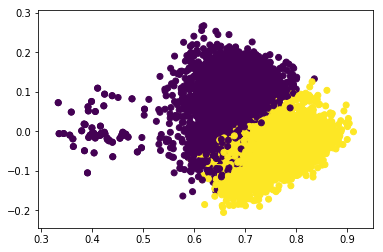

Comparing the assigned categories to the ones in the data:
col_0                  0     1
taster_name                   
Alexander Peartree     2    29
Anna Lee C. Iijima    43   265
Anne Krebiehl MW      36   234
Carrie Dykes           0    10
Fiona Adams            0     1
Jeff Jenssen          12    19
Jim Gordon           135   205
Joe Czerwinski        67   332
Kerin O’Keefe        171   597
Lauren Buzzeo         18   134
Matt Kettmann          8   460
Michael Schachner     51  1131
Mike DeSimone          4    37
Paul Gregutt         130   549
Roger Voss          1720   111
Sean P. Sullivan     125   290
Susan Kostrzewa        9    69
Virginie Boone       161   582


In [27]:
from sklearn.cluster import SpectralClustering

n_clusters=2

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train_lsa)

#Predicted clusters.
predict=sc.fit_predict(X_train_lsa)

#Graph results.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))